
# Medical Costs Prediction Model
### Introduction
Our goal for this project is to create a machine learning model that can accurately predict a patients insurance costs from hospital fees based on 6 classifiers/features. 

### Why?

Americans are faced with crippling medical debt frequently with no sign of help on the horizon. We set out to determine if medical costs could be accurately predicted based on factors that are not specifically related to a patients reason for intake. This report could help people see if certain aspects of their daily life reflect in worse medical bills. With questions such as, "If I smoke am I more likely to end up with a larger hospital bill? If so, what range would I be looking to pay?" 

Medical debt is an ever growing problem in America. According to the Debt.com, a consumer financial education company, 57% of Americans have medical debt totaling over $\$1000$. In the wake of the COVID-19 pandemic, millions are left with hospital bills. A JAMA study showed that debt collectors hold $140 billion in medical debt which doesn't include credit card balances and unpaid medical bills that have yet to hit consumers' credit reports. 

### How might this model be useful?
This model has the potential to educate readers on the potential negative side effects of their daily habits. If a reader is overweight or a smoker they are going to be able to see if that leads to a larger medical bill overall compared to people that are not. 

### Importing Data

This project is using a medical costs dataset from the textbook, *Machine Learning with R* by Brett Lantz. This dataset was uploaded onto [Kaggle.com](https://www.kaggle.com/mirichoi0218/insurance) which is where our group downloaded it from. 

Below is a list of the features and label in our dataset.
#### Features
- `age` : The age of the primary beneficiary.
- `sex` : The gender (female/male) of the primary beneficiary.
- `bmi` : The body mass index of the primary beneficiary, providing an understanding of body weights that are relatively high or low relative to height. An objective index of body weight (kg/m^2) using the ratio of height to weight, is ideally 18.5 to 24.9.
- `children` : The number of children covered by health insurance / number of dependents.
- `smoker` : A yes or no if the primary beneficiary is a smoker.
- `region` : The primary beneficiary's residential area in the US, northeast,southeast,southwest,northwest.
#### Label
- `charges`: The individual medical costs billed by health insurance.


In [91]:
#import sys
#!{sys.executable} -m pip install xgboost

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import math
import sklearn
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,f1_score,plot_confusion_matrix,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,cross_val_score
import warnings

In [93]:
df = pd.read_csv('insurance.csv')


## Data Cleaning

In [94]:
#DATA CLEANING

#we want to check to make sure there are no null values in the dataset 
print(pd.isna(df).sum())
#we dont want children or region they arent informative
#df = df.drop(columns= ['children','region'])
#df

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [95]:

df_copy = df

#we want to change charges so that it is categorical and can run models on it without problems
#but with so many different values we will get terrible encoding
#so we are going to group the insurance bills by intervals of $5000
#we will overcome potential overfitting by using cross validation and other methods
bins = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000]
names = ['<5000','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','60-65',]
df_copy['charges'] = pd.cut(df_copy['charges'],bins,labels=names)


In [96]:
#making sure the new codes line up with our bin values
pd.Categorical(df_copy.charges).codes
#now we can insert the new codes into the df.charges column
df_copy.charges = df_copy['charges'].cat.codes


df_copy.charges.value_counts()
#we can see that everything has been changed over

0     359
1     353
2     268
3      85
4      72
7      54
8      41
5      39
9      31
6      29
12      3
10      2
11      2
Name: charges, dtype: int64

In [97]:
#same thing with smoker no = 0 and yes = 1
df_copy.smoker = df_copy.smoker.astype('category')
df_copy.smoker = df_copy.smoker.cat.codes

#same thing with genders 0 female 1 male
df_copy.sex = df_copy.sex.astype('category')
df_copy.sex = df_copy.sex.cat.codes


## Exploratory Data Analysis

This entire exploratory data analysis is going to be based solely on the training set, which has 1,070 observations. Each observation represents a single insurance policy holder. We can start by analyzing the relationships between each feature and the insurance costs. 

### Age
We hypothesize that beneficiary's who are older will more than likely have a higher insurance bill. We can start by looking at the dataset and determining if there is any skewed data.

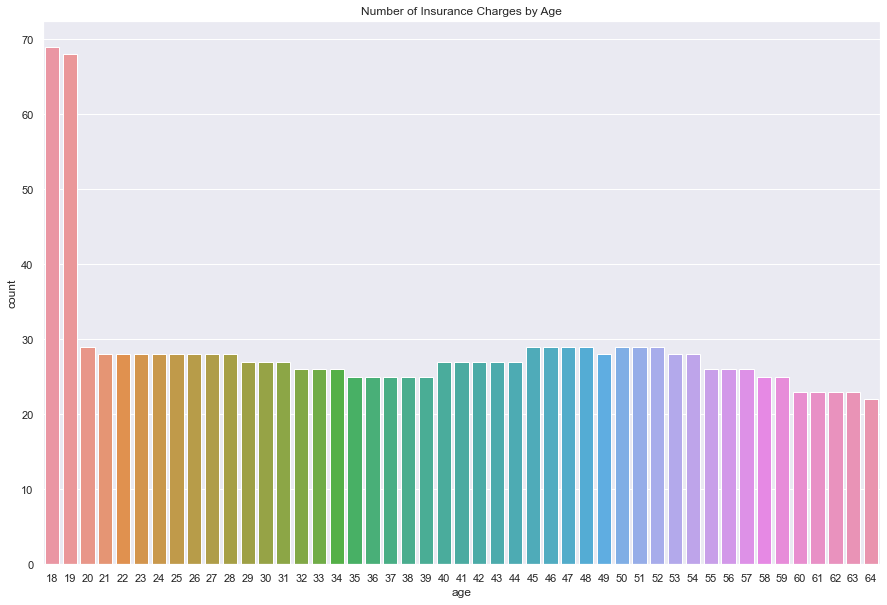

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#countplot showing the various ages of beneficiaries
sns.set_theme(style="darkgrid")
plt.figure(figsize = (15,10))
age_plot = sns.countplot(data=df_copy, x='age').set(title='Number of Insurance Charges by Age')

We can see that the data is primarily even throughout besides the beneficiaries aged 18 and 19. These appear to be outliers. 

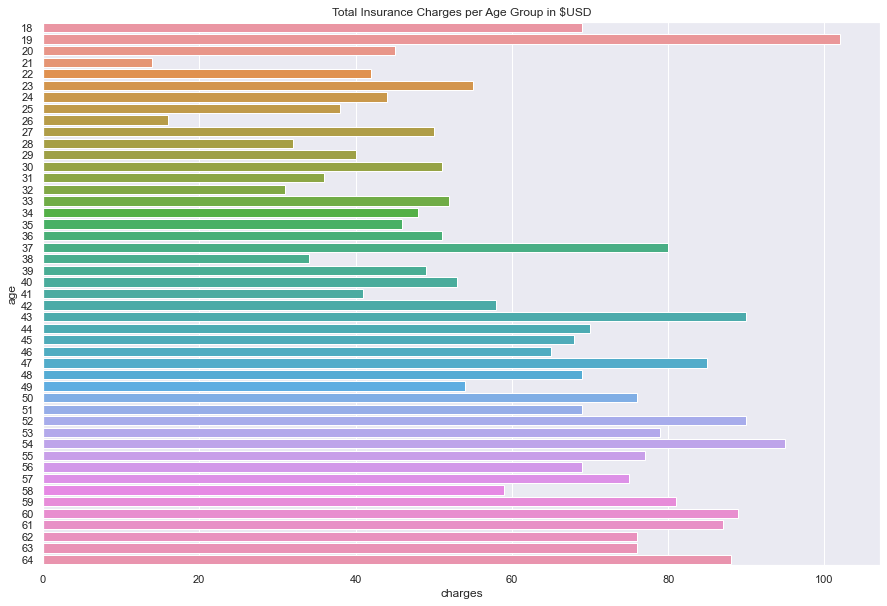

In [99]:
#barplot showing the insurance bills total of each age
plt.figure(figsize = (15,10))
total_charges_age = sns.barplot(y=df_copy.age,x=df_copy.charges,ci=None, estimator=sum, orient='h').set(title='Total Insurance Charges per Age Group in $USD')

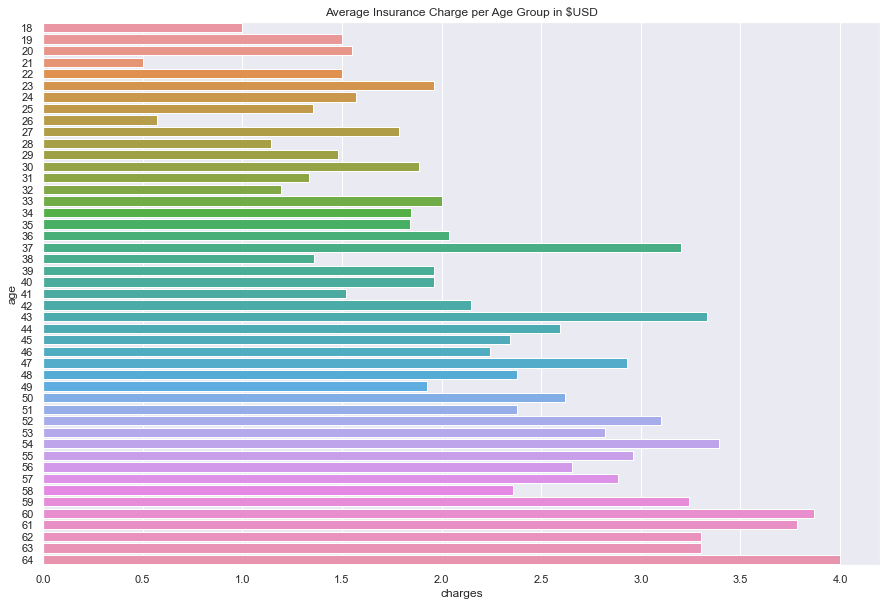

In [100]:
#barplot showing the insurance bills average of each age
plt.figure(figsize = (15,10))
avg_charges_age = sns.barplot(y=df_copy.age,x=df_copy.charges,ci=None, estimator=np.mean,orient='h').set(title='Average Insurance Charge per Age Group in $USD')

We can see that age 19 has the highest insurance bill overall, but individually, they are on the lower end of the spectrum with regards to average insurance bills. You can make the inference that young people need medical help for small things more often and older people need medical help for more serious matters less often. Also the relationship showing that young people have cheap medical bills vs older people having much higher medical bills.

### Sex
There is a peculiar sentiment among people that women are likely to live longer because men are more likely to put themselves in danger. Whether it is their job or just their pride, trying to find a relationship with gender and how costly the insurance bill is will be interesting. 

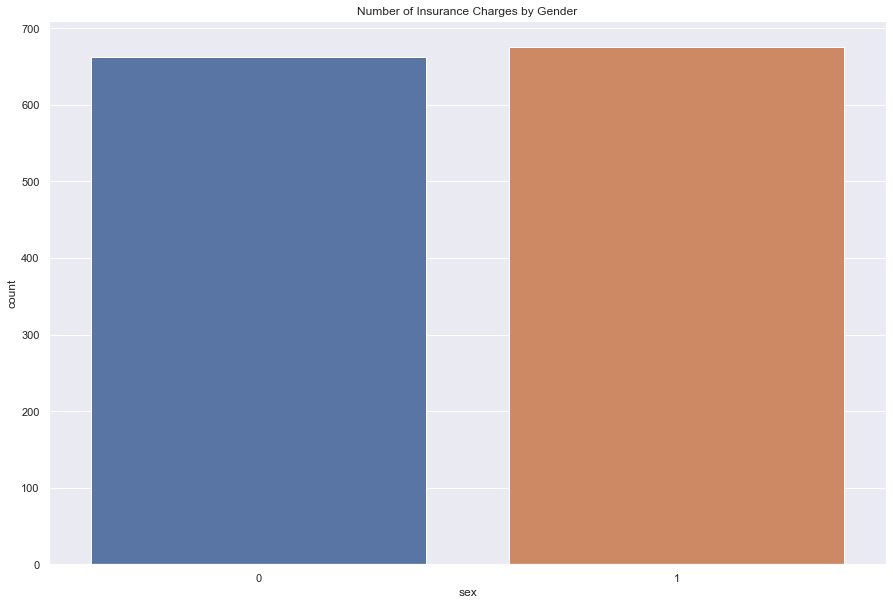

In [101]:
plt.figure(figsize = (15,10))
gender_plot = sns.countplot(data=df_copy, x='sex').set(title='Number of Insurance Charges by Gender')

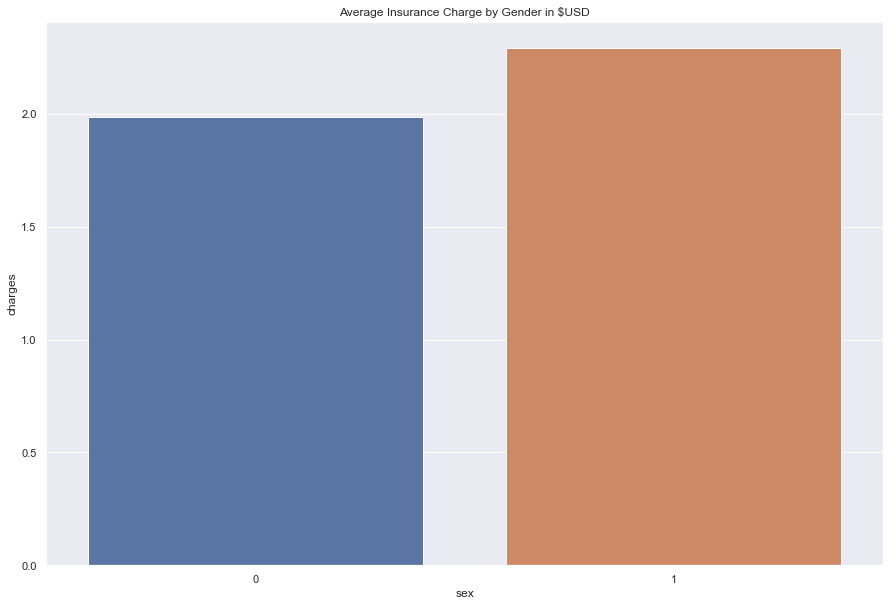

In [102]:
#barplot showing the insurance bills average of each age
plt.figure(figsize = (15,10))
avg_charges_gender = sns.barplot(x=df_copy.sex,y=df_copy.charges,ci=None, estimator=np.mean).set(title='Average Insurance Charge by Gender in $USD')

We can see that although there are an even number of male to female observations, male beneficiary's tend to have higher insurance charges from our dataset. This confirms the initial thought that men are more likely to be in dangerous situations and are thus more likely to have higher insurance charges. Of course we cannot say for 100% certainty if this correlation equals causation, but from the data it seems to be the case. 

### BMI

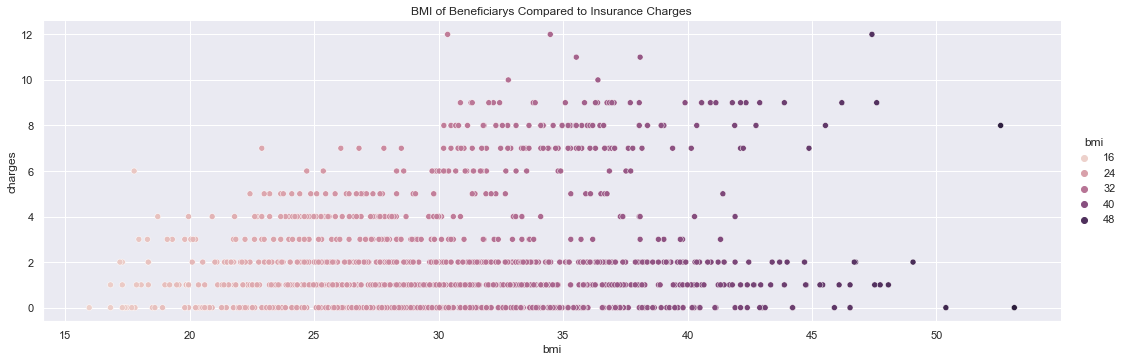

In [103]:
#dotplot comparing the insurance beneficiary's bmi and insurance charge. 
charges_bmi=sns.relplot(data=df_copy, x='bmi', y=df_copy.charges, hue='bmi',height=5,aspect=3).set(title='BMI of Beneficiarys Compared to Insurance Charges')

In [104]:
#average bmi of the dataset
df_copy.bmi.sum()/len(df_copy)

30.66339686098655

Looking at the bmi of our dataset shows that at the very least there seems to be a correlation with higher insurance charges and higher bmi. This could potentially be just outliers in a dataset but we can say for sure that the outliers of low bmi observations(<30) have a lower max insurance charge compared to the higher bmi observations(>30). 

### Children

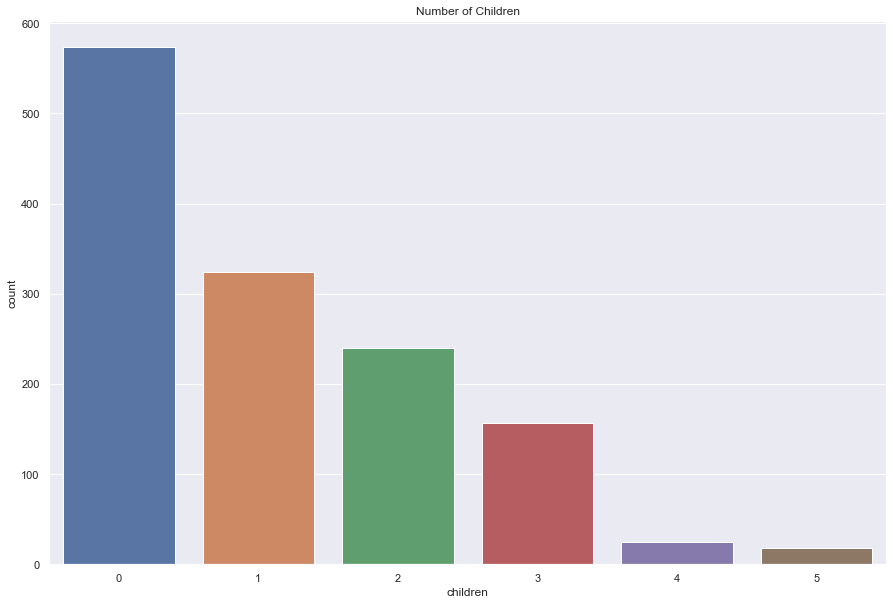

In [105]:
#countplot showing totals of each children group
plt.figure(figsize = (15,10))
children_plot = sns.countplot(data=df_copy, x='children').set(title='Number of Children')

In [106]:
#we can see totals of each number of children group
df_copy.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

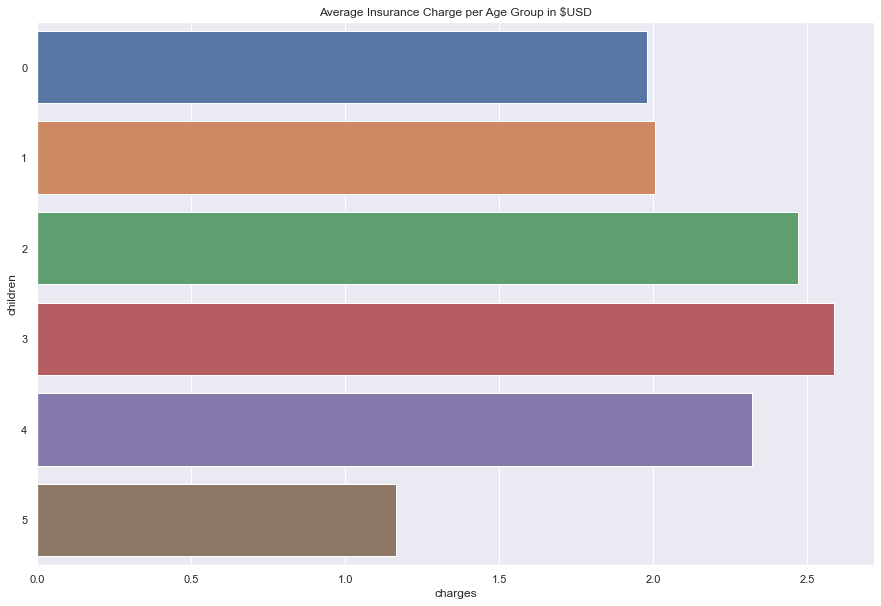

In [107]:
#barplot showing the insurance bills average based on how many children you have
plt.figure(figsize = (15,10))
avg_charges_children = sns.barplot(y=df_copy.children,x=df_copy.charges,ci=None, estimator=np.mean,orient='h').set(title='Average Insurance Charge per Age Group in $USD')

When plotting number of children against their insurance charges there seems to be a positive relationship up until 3 children that coincide with the idea of more children means higher insurance charges. But that claim is proven untrue when insurance charges where the family has 4 or 5 children are on average much lower than families with 3 children and lower. This feature is proving to be not as helpful as originally thought and may have to be cut from the model. 

### Smoker

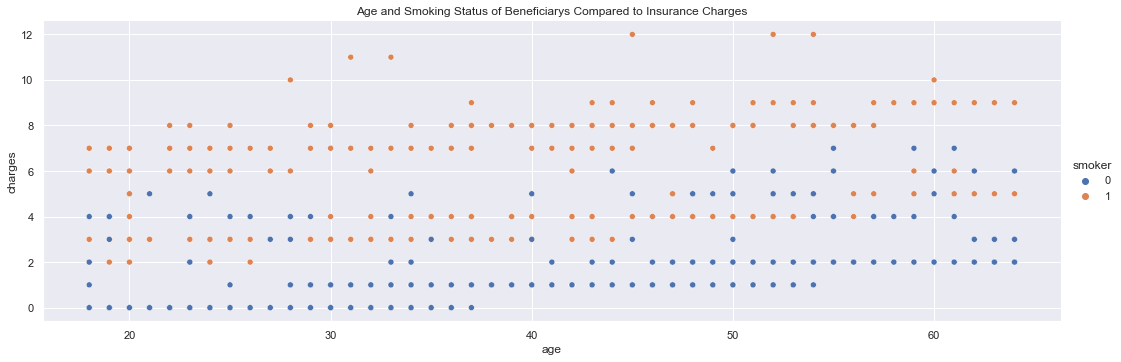

In [108]:
#dotplot comparing the insurance beneficiary's smoking status and insurance charge. 
charges_age_smoking=sns.relplot(data=df_copy, x='age', y=df_copy.charges, hue='smoker',height=5,aspect=3).set(title='Age and Smoking Status of Beneficiarys Compared to Insurance Charges')

In order to get a better visual we paired age and smoking status with insurance charges. We were very happy to see that age and smoking status are most likely going to be the most impactful features for the model. There is a very easy to see correlation with non smokers having low insurance charges and smokers having high insurance charges. There are some outliers but this seems to be very clear cut. 

### Region

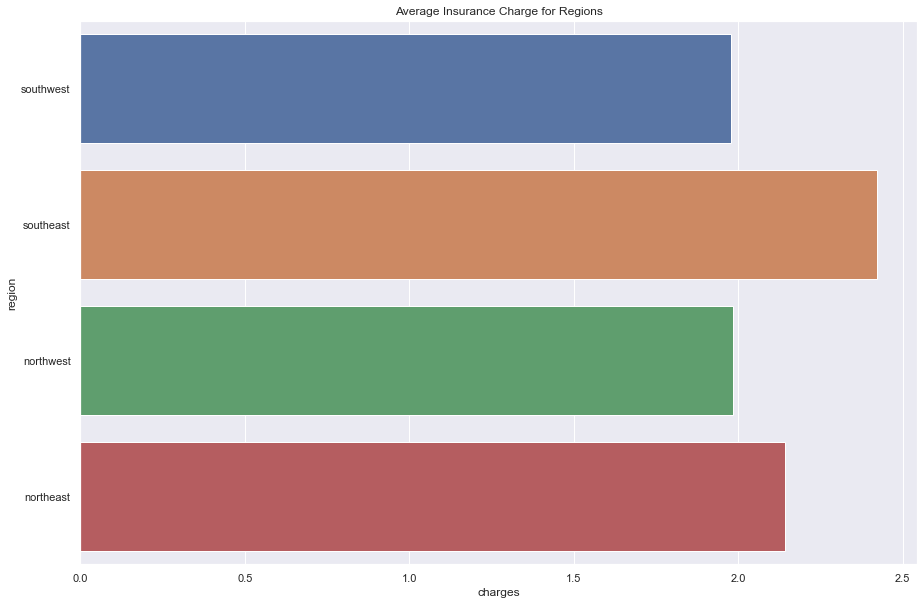

In [109]:
#barplot showing the insurance bills average based on how many children you have
plt.figure(figsize = (15,10))
avg_charges_children = sns.barplot(y=df_copy.region,x=df_copy.charges,ci=None, estimator=np.mean,orient='h').set(title='Average Insurance Charge for Regions')

Looking at the regions, we are most likely going to be dropping this feature as well. There doesn't seem to be any relationship to be made with regards to the region where the beneficiary is located. 

### Splitting Dataset

In [110]:
warnings.filterwarnings("ignore")

#we dont want children or region they arent informative

X = df_copy.drop(['charges','children','region'], axis = 1)
y = df_copy.charges
#x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25 ,random_state = 0 )
df2 = df_copy.drop(['children','region'], axis = 1) # for graphing

## Building Models



In [111]:
#using RepeatedStratifiedKFold from sklearn to stratify our training and testing datasets so we get the same proportions with regards to age
#3 folds and 10 cross validation repeats
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=7)

def training_model(rskf,X_train,y_train,X_test,y_test,model): #creating a function to run any model
    model.fit(X_train, y_train) #evaluating the model on training dataset
    score = model.score(X_test,y_test) #evaluating accuracy of the model using testing dataset to make predictions
    print('For fold {} the accuracy is {}'.format(str(fold_num),score))
    
    return score

### K-Nearest Neighbors (KNN)

**First we will start with a K-Nearest Neighbors model!** 

In [112]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
fold_num = 1 #starting at 1 fold to 30 based on n_splits/n_repeats in rskf
#choosing K nearest neighbors classifer
model = KNeighborsClassifier() #choose whatever model you want
knn_scores = []
for train_index, test_index in rskf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index) just used to test it out
    #rskf splits the df into train and test datasets so initilize
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    knn_avg = training_model(rskf,X_train,y_train,X_test,y_test,model)
    knn_scores.append(knn_avg)
    fold_num += 1

#we can see that the model was split correctly
#we need to remember and probably say that since there are bin 10 and 11 having only 2 values the proportion will be slightly skewed.
print(f"The average score for the K-Nearest Neighbors Model is: {np.mean(knn_scores)}")

For fold 1 the accuracy is 0.6457399103139013
For fold 2 the accuracy is 0.6547085201793722
For fold 3 the accuracy is 0.6188340807174888
For fold 4 the accuracy is 0.6502242152466368
For fold 5 the accuracy is 0.6367713004484304
For fold 6 the accuracy is 0.672645739910314
For fold 7 the accuracy is 0.6390134529147982
For fold 8 the accuracy is 0.6457399103139013
For fold 9 the accuracy is 0.6210762331838565
For fold 10 the accuracy is 0.6322869955156951
For fold 11 the accuracy is 0.6502242152466368
For fold 12 the accuracy is 0.6322869955156951
For fold 13 the accuracy is 0.6524663677130045
For fold 14 the accuracy is 0.6434977578475336
For fold 15 the accuracy is 0.647982062780269
For fold 16 the accuracy is 0.6412556053811659
For fold 17 the accuracy is 0.6390134529147982
For fold 18 the accuracy is 0.6591928251121076
For fold 19 the accuracy is 0.6322869955156951
For fold 20 the accuracy is 0.6457399103139013
For fold 21 the accuracy is 0.6524663677130045
For fold 22 the accuracy

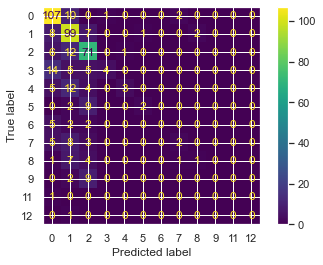

In [113]:
#now we can plot confusion matrix to see how accurate the model was
plot_confusion_matrix(model,X_test,y_test)

In [114]:
#we can also look at the F-score
#measuring precision and recall, best score is 1, worst is 0.
#micro - Calculate metrics globally by counting the total true positives, false negatives and false positives
print('F1 score is {}'.format(f1_score(y_test,model.predict(X_test),average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

F1 score is 0.647982062780269
RMSE: 2.587916037478874


**After testing the model we can see that it is probably not the correct model for this type of data. But we will try to tune it to see if we can make it better.**

In [115]:
knn_model_tuning = KNeighborsClassifier()
parameters = {'leaf_size': [1,10,20,50],
              'n_neighbors': [1,2,3,4,5,10,30],
              'p': [1, 2]}


GSCV = GridSearchCV(estimator=knn_model_tuning, param_grid=parameters, cv=5)
GSCV.fit(X_train, y_train)
params=GSCV.best_params_
params

{'leaf_size': 10, 'n_neighbors': 5, 'p': 1}

In [116]:
knn_model=KNeighborsClassifier(**params)
knn_model.fit(X_train,y_train)
y_pred = knn_model.predict(X_test)


res=y_test-y_pred

print('F1 score is {}'.format(f1_score(y_test,y_pred,average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))

F1 score is 0.6771300448430493
RMSE: 2.3628287371825336


**After tuning we can see that the model is still not very accurate so we will test other models.**

### Support Vector Classification (SVM)

**Next we will try another classification model, the Support Vector Classification Model.**

In [117]:
from sklearn.svm import SVC

fold_num = 1 #starting at 1 fold to 30 based on n_splits/n_repeats in rskf
#choosing SVM classifer
svm_scores = []
model = SVC(kernel='poly') #choose whatever model you want
for train_index, test_index in rskf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index) just used to test it out
    #rskf splits the df into train and test datasets so initilize
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    svm = training_model(rskf,X_train,y_train,X_test,y_test,model)
    svm_scores.append(svm)
    fold_num += 1
print(f"The average score for the SVM Classifier Model is: {np.mean(svm_scores)}")

For fold 1 the accuracy is 0.6434977578475336
For fold 2 the accuracy is 0.6524663677130045
For fold 3 the accuracy is 0.6165919282511211
For fold 4 the accuracy is 0.6502242152466368
For fold 5 the accuracy is 0.6345291479820628
For fold 6 the accuracy is 0.647982062780269
For fold 7 the accuracy is 0.647982062780269
For fold 8 the accuracy is 0.6345291479820628
For fold 9 the accuracy is 0.647982062780269
For fold 10 the accuracy is 0.6300448430493274
For fold 11 the accuracy is 0.6681614349775785
For fold 12 the accuracy is 0.6367713004484304
For fold 13 the accuracy is 0.6524663677130045
For fold 14 the accuracy is 0.6233183856502242
For fold 15 the accuracy is 0.6457399103139013
For fold 16 the accuracy is 0.6322869955156951
For fold 17 the accuracy is 0.6345291479820628
For fold 18 the accuracy is 0.6591928251121076
For fold 19 the accuracy is 0.6322869955156951
For fold 20 the accuracy is 0.6390134529147982
For fold 21 the accuracy is 0.647982062780269
For fold 22 the accuracy i

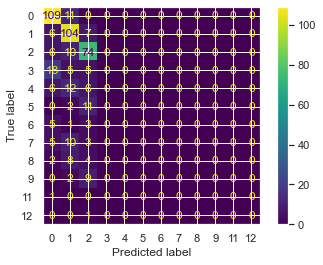

In [118]:
plot_confusion_matrix(model,X_test,y_test)

In [119]:
print('F1 score is {}'.format(f1_score(y_test,model.predict(X_test),average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

F1 score is 0.6434977578475336
RMSE: 2.589648243855877


**After testing we can see that is yeild similar results as the KNN model but we will still tune it to see if we can make it any better.**

In [120]:
svc_model_tuning = SVC()
parameters = {'kernel':['rbf'],
              'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01]}

GSCV = GridSearchCV(estimator=svc_model_tuning, param_grid=parameters, cv=5)
GSCV.fit(X_train, y_train)
params=GSCV.best_params_
params

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [121]:
svc_model=SVC(**params)
knn_model.fit(X_train,y_train)
y_pred = knn_model.predict(X_test)


res=y_test-y_pred


print('F1 score is {}'.format(f1_score(y_test,y_pred,average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))

F1 score is 0.6771300448430493
RMSE: 2.3628287371825336


**After tuning we can conclude that this model is not the best for this data either.**

### Random Forest Classifier

**We will give the classification models one last try with the Random Forest Classifier.**

In [122]:
fold_num = 1 #starting at 1 fold to 30 based on n_splits/n_repeats in rskf
#choosing random forest classifer
model = RandomForestClassifier() #choose whatever model you want
rfc_avg = []
for train_index, test_index in rskf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index) just used to test it out
    #rskf splits the df into train and test datasets so initilize
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc = training_model(rskf,X_train,y_train,X_test,y_test,model)
    rfc_avg.append(rfc)
    fold_num += 1
#we can see that the model was split correctly
#we need to remember and probably say that since there are bin 10 and 11 having only 2 values the proportion will be slightly skewed.
print(f"The average score for the Random Forest Classifier Model is: {np.mean(rfc_avg)}")

For fold 1 the accuracy is 0.7443946188340808
For fold 2 the accuracy is 0.7847533632286996
For fold 3 the accuracy is 0.7533632286995515
For fold 4 the accuracy is 0.7600896860986547
For fold 5 the accuracy is 0.7376681614349776
For fold 6 the accuracy is 0.7690582959641256
For fold 7 the accuracy is 0.7623318385650224
For fold 8 the accuracy is 0.7668161434977578
For fold 9 the accuracy is 0.7399103139013453
For fold 10 the accuracy is 0.773542600896861
For fold 11 the accuracy is 0.7713004484304933
For fold 12 the accuracy is 0.7399103139013453
For fold 13 the accuracy is 0.7645739910313901
For fold 14 the accuracy is 0.7466367713004485
For fold 15 the accuracy is 0.7802690582959642
For fold 16 the accuracy is 0.7533632286995515
For fold 17 the accuracy is 0.7690582959641256
For fold 18 the accuracy is 0.7623318385650224
For fold 19 the accuracy is 0.7802690582959642
For fold 20 the accuracy is 0.7600896860986547
For fold 21 the accuracy is 0.7623318385650224
For fold 22 the accurac

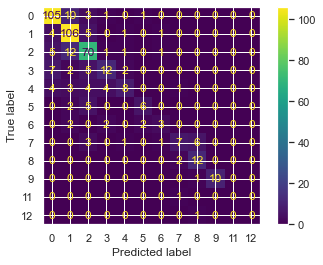

In [123]:
#now we can plot confusion matrix to see how accurate the model was
plot_confusion_matrix(model,X_test,y_test)

In [124]:
#we can also look at the F-score
#measuring precision and recall, best score is 1, worst is 0.
#micro - Calculate metrics globally by counting the total true positives, false negatives and false positives
print('F1 score is {}'.format(f1_score(y_test,model.predict(X_test),average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

F1 score is 0.7600896860986546
RMSE: 1.1818887369575384


**After testing we have seen a clear improvement of accuracy with this model. Now we will try to tune it to make it better.**

In [125]:
rfc_model_tuning = RandomForestClassifier()
parameters = {'max_depth': [1, 3, 7, 25],
              'n_estimators': [25, 50, 100]}

GSCV = GridSearchCV(estimator=rfc_model_tuning, param_grid=parameters, cv=5)
GSCV.fit(X_train, y_train)
params=GSCV.best_params_
params

{'max_depth': 7, 'n_estimators': 100}

In [126]:
rfc_model=RandomForestClassifier(**params)
rfc_model.fit(X_train,y_train)
y_pred = rfc_model.predict(X_test)


res=y_test-y_pred

print('F1 score is {}'.format(f1_score(y_test,y_pred,average='micro')))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))

F1 score is 0.7802690582959642
RMSE: 1.0901104564102153


**So far this is the best model we have created with a fair accuracy. But we can do better.**

### XGBOOST Regressor Model

**Lets move on to some regression model. We will start with a XGBoost Regressor.**

In [127]:
#xgb_model=xgb.XGBRegressor()
#xgb_model.fit(x_train,y_train)
#y_pred = xgb_model.predict(x_test)
#r2_score(y_test,y_pred)
fold_num = 1
xg_boost_avg = []
model = xgb.XGBRegressor(objective ='reg:squarederror',) #choose whatever model you want
for train_index, test_index in rskf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index) just used to test it out
    #rskf splits the df into train and test datasets so initilize
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_boost = training_model(rskf,X_train,y_train,X_test,y_test,model)
    xg_boost_avg.append(xg_boost)
    fold_num += 1
print(f"The average score for the XG Boost Regressor Model is: {np.mean(xg_boost_avg)}")

For fold 1 the accuracy is 0.7447968155011192
For fold 2 the accuracy is 0.8063552695912114
For fold 3 the accuracy is 0.7606277549587803
For fold 4 the accuracy is 0.7855140257832951
For fold 5 the accuracy is 0.7359063950565423
For fold 6 the accuracy is 0.7861443601399776
For fold 7 the accuracy is 0.7782835089304908
For fold 8 the accuracy is 0.7930887220670368
For fold 9 the accuracy is 0.7664568285359132
For fold 10 the accuracy is 0.7627058286964365
For fold 11 the accuracy is 0.8066752618411038
For fold 12 the accuracy is 0.7340435967286174
For fold 13 the accuracy is 0.7979522353983257
For fold 14 the accuracy is 0.7780949440217966
For fold 15 the accuracy is 0.7709985878668596
For fold 16 the accuracy is 0.7937685580877698
For fold 17 the accuracy is 0.7657989342176491
For fold 18 the accuracy is 0.7822614679537764
For fold 19 the accuracy is 0.7544950254006035
For fold 20 the accuracy is 0.7694890846630883
For fold 21 the accuracy is 0.7716071370057819
For fold 22 the accura

In [128]:
print('R2 score is {}'.format(r2_score(y_test,model.predict(X_test))))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

R2 score is 0.7582935880719036
RMSE: 1.1976737840417804


**We can see that our first regression model gave us a signicantly better accuracy than the classification models. Now lets try to tune it to make it better.**

In [129]:
xgb_model_tuning = xgb.XGBRegressor()
parameters = {
    'objective' : ['reg:squarederror'],
   'learning_rate':[0.01,0.1,0.2,0.3],
    'max_depth': [3,5,7,9],
    'n_estimators' : [5,10,50,100,250]
}
GSCV = GridSearchCV(estimator=xgb_model_tuning, param_grid=parameters, cv=5)
GSCV.fit(X_train, y_train)
params=GSCV.best_params_
params

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'objective': 'reg:squarederror'}

In [130]:
xgb_model=xgb.XGBRegressor(**params)
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

res=y_test-y_pred

r2_score(y_test,y_pred)
print('R2 score is {}'.format(r2_score(y_test,y_pred)))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))

R2 score is 0.826016464791798
RMSE: 1.0161282979578743


**After tuning our model it had a slight improvement.**

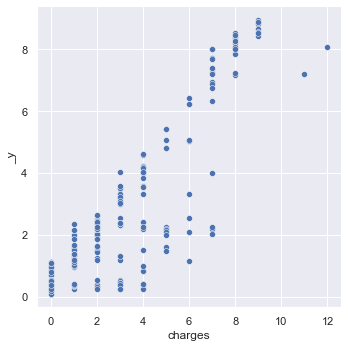

In [131]:
sns.relplot(x=y_test,y=y_pred)

### Random Forest Regressor Model

**Although our last regression model gave us good results lets try the Random Forest Regressor to see if we can get any improvement.**

In [132]:
fold_num = 1
model = RandomForestRegressor() #choose whatever model you want
rfg_avg = []
for train_index, test_index in rskf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index) just used to test it out
    #rskf splits the df into train and test datasets so initilize
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfg = training_model(rskf,X_train,y_train,X_test,y_test,model)
    rfg_avg.append(rfg)
    fold_num += 1
print(f"The average score for the Random Forest Regressor Model is: {np.mean(rfg_avg)}")

For fold 1 the accuracy is 0.7738541096320165
For fold 2 the accuracy is 0.841919678436953
For fold 3 the accuracy is 0.7948951270293063
For fold 4 the accuracy is 0.8003554460528676
For fold 5 the accuracy is 0.7919486839054434
For fold 6 the accuracy is 0.8170773587015451
For fold 7 the accuracy is 0.8015063332472556
For fold 8 the accuracy is 0.813331014280905
For fold 9 the accuracy is 0.8085485156927219
For fold 10 the accuracy is 0.8074217327009725
For fold 11 the accuracy is 0.8302394992540431
For fold 12 the accuracy is 0.7655843488433949
For fold 13 the accuracy is 0.8293635323096282
For fold 14 the accuracy is 0.7875040060570008
For fold 15 the accuracy is 0.7994033189052177
For fold 16 the accuracy is 0.8256563685321473
For fold 17 the accuracy is 0.7995772689633281
For fold 18 the accuracy is 0.8020040842660989
For fold 19 the accuracy is 0.800264363198824
For fold 20 the accuracy is 0.7971549582986979
For fold 21 the accuracy is 0.8203490190148639
For fold 22 the accuracy 

In [133]:
print('R2 score is {}'.format(r2_score(y_test,model.predict(X_test))))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

R2 score is 0.7934821997223822
RMSE: 1.1070652105819319


**This regressor yeilded slightly worse results than the XGBoost but with tuning lets see if we can improve it.**

In [134]:
random_forest_tuning = RandomForestRegressor(random_state = 10)
parameters = {
   'n_estimators': [5,50,100],
   'max_depth' : [2,4,8,16,32]
}
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=parameters, cv=5)
GSCV.fit(X_train, y_train)
params=GSCV.best_params_
params

{'max_depth': 4, 'n_estimators': 100}

In [135]:
forest_model=RandomForestRegressor(**params)
forest_model.fit(X_train,y_train)
y_pred = forest_model.predict(X_test)


res=y_test-y_pred

print('R2 score is {}'.format(r2_score(y_test,y_pred)))
print('RMSE: {}'.format(math.sqrt(mean_squared_error(y_test,y_pred))))

R2 score is 0.8247997994025301
RMSE: 1.0196749672109082


**After tuning we can see that both the XGboost and Random Forest Regressor yield very similar results.**

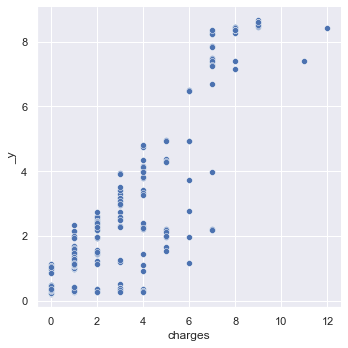

In [136]:
sns.relplot(x=y_test,y=y_pred)

## Results

| Model       |RMSE Value         | Tuned Value       | Average Accuracy Value | Avg Accuracy % |
| ----------- |----------- | ----------- | ----------- | ----------- |
| K-Nearest Neighbors (KNN)    |2.5897 | 2.363 | 0.645 | 64.5% |
| Support Vector Classification (SVM)    | 1.177 | 1.091| 0.642 | 64.2% |
| Random Forest Classifier       |  2.592 | 2.363 | 0.762 | 76.2% |
| XGBOOST Regressor Model  | 1.198 | 1.016 | 0.772 | 77.2% |
| Random Forest Regressor      |  1.0998 | 1.018 | 0.806 | 80.6% |

## Conclusion

In this project we had the goal of predicting medical insurances charges for patients based on the parameters included in the dataset. The parameters ranged from the lifestyle, health, sex and where the patient resides in the country. After some analysis we concluded that the region and the amount of children the patient had little to no measurable effect on the charges for the patients so they were removed from the data frame then model building was started. We quickly decided to forgo a traditional linear regression approach and try for models based more in the machine learning realm.

Our best performing models seem to be the boosting and random forests with the boosting coming out slightly better. With a tuned  R2 value of 82.6% our XGBOOST Regressor Model was able to explain most of the varation in charges. The XGBOOST Regressor also had a RMSE that was closest to 1. The result for our best perfoming model is slightly surpising because we expected our Random Forest models would end up being the best performing because our data frame includes many categorical varaibles that seems to have a significant effect on charges.   
